In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset
We are using MNIST dataset for our model

In [2]:
# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image or numpy.ndarray to tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize pixel values
])

# Load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 55.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.87MB/s]


## Show a sample of image

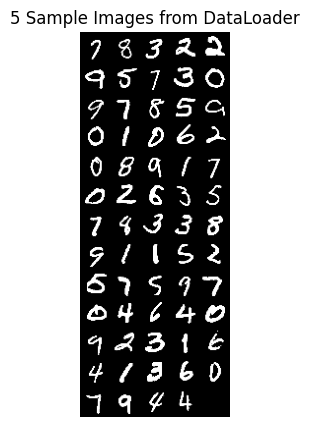

In [3]:
# Get one batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Create a grid and show
img_grid = torchvision.utils.make_grid(images, nrow=5)

plt.figure(figsize=(5, 5))
plt.imshow(img_grid.permute(1, 2, 0))  # CHW to HWC
plt.axis('off')
plt.title('5 Sample Images from DataLoader')
plt.show()


# Model

In [4]:
# Generator: input is noise vector (latent_dim), output is 28x28 image (flattened)
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, z):
        return self.model(z)


# Discriminator: input is 28x28 image (flattened), output is real/fake
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output: probability
        )

    def forward(self, x):
        return self.model(x)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

latent_dim = 100
batch_size = 64
lr = 0.0002
epochs = 50

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers and loss
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)


cuda


In [6]:
for epoch in tqdm(range(epochs)):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.view(-1, 784).to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")


  2%|▏         | 1/50 [00:16<13:51, 16.97s/it]

Epoch [1/50]  Loss D: 0.9891, Loss G: 0.8896


  4%|▍         | 2/50 [00:32<13:03, 16.32s/it]

Epoch [2/50]  Loss D: 0.9311, Loss G: 1.0576


  6%|▌         | 3/50 [00:49<12:44, 16.26s/it]

Epoch [3/50]  Loss D: 1.2584, Loss G: 0.7703


  8%|▊         | 4/50 [01:04<12:20, 16.09s/it]

Epoch [4/50]  Loss D: 1.1589, Loss G: 0.9276


 10%|█         | 5/50 [01:20<11:58, 15.98s/it]

Epoch [5/50]  Loss D: 1.2943, Loss G: 0.9108


 12%|█▏        | 6/50 [01:35<11:31, 15.72s/it]

Epoch [6/50]  Loss D: 1.2811, Loss G: 0.8630


 14%|█▍        | 7/50 [01:51<11:15, 15.70s/it]

Epoch [7/50]  Loss D: 1.5608, Loss G: 0.7637


 16%|█▌        | 8/50 [02:07<10:59, 15.70s/it]

Epoch [8/50]  Loss D: 1.4145, Loss G: 0.6494


 18%|█▊        | 9/50 [02:22<10:35, 15.50s/it]

Epoch [9/50]  Loss D: 1.2489, Loss G: 1.0233


 20%|██        | 10/50 [02:37<10:20, 15.52s/it]

Epoch [10/50]  Loss D: 0.9632, Loss G: 1.2918


 22%|██▏       | 11/50 [02:53<10:03, 15.47s/it]

Epoch [11/50]  Loss D: 0.8799, Loss G: 1.2847


 24%|██▍       | 12/50 [03:08<09:49, 15.50s/it]

Epoch [12/50]  Loss D: 0.9196, Loss G: 1.3020


 26%|██▌       | 13/50 [03:24<09:32, 15.48s/it]

Epoch [13/50]  Loss D: 0.8586, Loss G: 1.2551


 28%|██▊       | 14/50 [03:39<09:17, 15.49s/it]

Epoch [14/50]  Loss D: 0.7630, Loss G: 1.5532


 30%|███       | 15/50 [03:55<09:01, 15.48s/it]

Epoch [15/50]  Loss D: 0.7387, Loss G: 1.3954


 32%|███▏      | 16/50 [04:10<08:46, 15.48s/it]

Epoch [16/50]  Loss D: 0.9075, Loss G: 1.1905


 34%|███▍      | 17/50 [04:26<08:31, 15.49s/it]

Epoch [17/50]  Loss D: 1.2110, Loss G: 1.1897


 36%|███▌      | 18/50 [04:41<08:18, 15.57s/it]

Epoch [18/50]  Loss D: 0.6575, Loss G: 1.5459


 38%|███▊      | 19/50 [04:57<08:00, 15.50s/it]

Epoch [19/50]  Loss D: 1.2756, Loss G: 1.3169


 40%|████      | 20/50 [05:12<07:44, 15.47s/it]

Epoch [20/50]  Loss D: 1.0660, Loss G: 1.4589


 42%|████▏     | 21/50 [05:28<07:27, 15.45s/it]

Epoch [21/50]  Loss D: 0.6008, Loss G: 1.9380


 44%|████▍     | 22/50 [05:43<07:13, 15.48s/it]

Epoch [22/50]  Loss D: 0.5324, Loss G: 1.9739


 46%|████▌     | 23/50 [05:58<06:56, 15.42s/it]

Epoch [23/50]  Loss D: 0.8706, Loss G: 1.7899


 48%|████▊     | 24/50 [06:14<06:41, 15.46s/it]

Epoch [24/50]  Loss D: 0.3962, Loss G: 2.0164


 50%|█████     | 25/50 [06:29<06:25, 15.41s/it]

Epoch [25/50]  Loss D: 1.3196, Loss G: 0.9579


 52%|█████▏    | 26/50 [06:45<06:10, 15.44s/it]

Epoch [26/50]  Loss D: 0.6004, Loss G: 1.9586


 54%|█████▍    | 27/50 [07:00<05:56, 15.49s/it]

Epoch [27/50]  Loss D: 1.0553, Loss G: 1.5131


 56%|█████▌    | 28/50 [07:16<05:41, 15.53s/it]

Epoch [28/50]  Loss D: 1.3238, Loss G: 1.3845


 58%|█████▊    | 29/50 [07:31<05:26, 15.53s/it]

Epoch [29/50]  Loss D: 0.6317, Loss G: 1.8172


 60%|██████    | 30/50 [07:47<05:10, 15.52s/it]

Epoch [30/50]  Loss D: 0.7780, Loss G: 1.3784


 62%|██████▏   | 31/50 [08:02<04:53, 15.43s/it]

Epoch [31/50]  Loss D: 0.5443, Loss G: 2.2473


 64%|██████▍   | 32/50 [08:18<04:37, 15.39s/it]

Epoch [32/50]  Loss D: 0.3943, Loss G: 2.3922


 66%|██████▌   | 33/50 [08:33<04:21, 15.36s/it]

Epoch [33/50]  Loss D: 0.6860, Loss G: 1.5750


 68%|██████▊   | 34/50 [08:48<04:07, 15.44s/it]

Epoch [34/50]  Loss D: 0.7099, Loss G: 1.9192


 70%|███████   | 35/50 [09:04<03:53, 15.58s/it]

Epoch [35/50]  Loss D: 0.5700, Loss G: 1.7754


 72%|███████▏  | 36/50 [09:21<03:41, 15.81s/it]

Epoch [36/50]  Loss D: 0.9428, Loss G: 1.6917


 74%|███████▍  | 37/50 [09:37<03:26, 15.92s/it]

Epoch [37/50]  Loss D: 0.8484, Loss G: 1.3134


 76%|███████▌  | 38/50 [09:53<03:12, 16.03s/it]

Epoch [38/50]  Loss D: 1.1589, Loss G: 1.6615


 78%|███████▊  | 39/50 [10:10<02:57, 16.13s/it]

Epoch [39/50]  Loss D: 0.9348, Loss G: 2.2795


 80%|████████  | 40/50 [10:26<02:41, 16.12s/it]

Epoch [40/50]  Loss D: 0.7156, Loss G: 2.2704


 82%|████████▏ | 41/50 [10:41<02:24, 16.02s/it]

Epoch [41/50]  Loss D: 0.3913, Loss G: 3.1950


 84%|████████▍ | 42/50 [10:57<02:07, 15.96s/it]

Epoch [42/50]  Loss D: 0.4889, Loss G: 2.4367


 86%|████████▌ | 43/50 [11:13<01:51, 15.92s/it]

Epoch [43/50]  Loss D: 0.8388, Loss G: 2.4011


 88%|████████▊ | 44/50 [11:29<01:35, 15.96s/it]

Epoch [44/50]  Loss D: 0.7243, Loss G: 2.5564


 90%|█████████ | 45/50 [11:45<01:19, 15.91s/it]

Epoch [45/50]  Loss D: 0.6028, Loss G: 1.9126


 92%|█████████▏| 46/50 [12:01<01:03, 15.94s/it]

Epoch [46/50]  Loss D: 1.1682, Loss G: 1.6197


 94%|█████████▍| 47/50 [12:17<00:47, 15.92s/it]

Epoch [47/50]  Loss D: 0.9559, Loss G: 1.9478


 96%|█████████▌| 48/50 [12:33<00:31, 15.93s/it]

Epoch [48/50]  Loss D: 0.7346, Loss G: 2.1592


 98%|█████████▊| 49/50 [12:49<00:15, 15.96s/it]

Epoch [49/50]  Loss D: 0.6151, Loss G: 2.4861


100%|██████████| 50/50 [13:05<00:00, 15.70s/it]

Epoch [50/50]  Loss D: 0.7282, Loss G: 2.0609


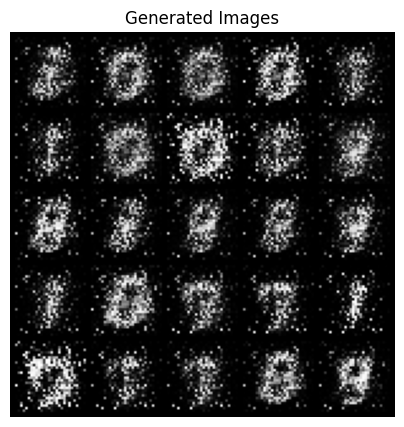

In [7]:
# Generate and visualize 25 fake images
z = torch.randn(25, latent_dim).to(device)
fake_imgs = generator(z).view(-1, 1, 28, 28)
fake_imgs = fake_imgs.cpu().detach()

grid = torchvision.utils.make_grid(fake_imgs, nrow=5, normalize=True)
plt.figure(figsize=(5,5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Generated Images")
plt.show()
